# Machine Learning Engineer Nanodegree

## Capstone Project

## Project: Build a Traffic Sign Recognition Classifier 

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: This project is actually the same project as the "Udacity Self-driving Car Nanodegree" Deep Learning Project. The dataset is also the same "pickled" dataset that is provided for this project in Udacity CarND.

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.

---
## Step 0: Import Modules and Load The Data

In [1]:
# import modules
import numpy as np
import pickle
from sklearn.cross_validation import train_test_split
import pandas as pd
from pandas import DataFrame
import warnings
warnings.filterwarnings(action="ignore", category=UserWarning)
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
from glob import glob

C:\Users\alip\programs\anaconda3\envs\py35-tf\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline

In [3]:
# Load pickled data
# TODO: Fill this in based on where you saved the training and testing data

training_file = "./datasets/training_data/train.p"
validation_file= None
testing_file = "./datasets/test_data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_, y_ = train['features'], train['labels']
#X_valid, y_valid = valid['features'], valid['labels']
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.25, random_state=2017)
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:

# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:] # this includes the width, height, and channels (colors).

# How many unique classes/labels there are in the dataset.
classes = pd.unique(y_train)
classes.sort()
n_classes = pd.unique(y_train).shape[0]

print("Number of training examples = {}".format(n_train))
print("Number of testing examples = {}".format(n_test))
print("Image data shape = {}".format(image_shape))
print("Number of classes = {}".format(n_classes))

Number of training examples = 29406
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [5]:
# Following we take a look at the top sign names
sign_map = pd.read_csv("./signnames.csv", index_col="ClassId")
sign_map.head()

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

In [6]:
''' This class helps in visualization tasks'''

class Visuals(object):
    # The initializer
    def __init__(self, X=None, y=None):
        self.X = X
        self.y = y
    
    # This method is used to plot a few samples of each sign. gray_scale flag should be set to True for preprocessed images
    def plot_all_signs(self, gray_scale=False, n_classes=n_classes, n_samples=8, image_size=1.5):
        
        for i in range(n_classes):
            print('Class ID: {}  |  Sign Name : {}'.format(i, sign_map.ix[i].values[0]))
            figure = plt.figure(figsize=(n_samples * image_size, image_size))
            
            for j in range(n_samples):
                sample = self.X[np.where(self.y == i)[0][j]]
                ax = figure.add_subplot(1, n_samples, j + 1, xticks=[], yticks=[])
                
                if gray_scale:
                    ax.imshow(sample.squeeze(), cmap=plt.cm.gray)
                else:
                    ax.imshow(sample)
            plt.show()
    
    # This method provides the histogram (sample vs density) of the input data
    def plot_hist(self, data=None, title=None):
        if data is None:
            data = self.y
            if title is None:
                title = 'Training Data'
        plt.figure(figsize=(8, 3))
        plt.hist(data, bins=classes, normed=True)
        plt.xlabel('sign ID')
        plt.ylabel('Density')
        plt.title(title)
        plt.grid(True)
        plt.show()
        
    # This method simply displays an image with a certain size.
    def display_image(self, image, true_class, gray_scale=False, show_title=True, figsize=(2, 2)):
        figure = plt.figure(figsize=figsize)
        if show_title:
            print('The true label of the sign is: {}'.format(true_class))
        if gray_scale:
            plt.imshow(image.squeeze(), cmap=plt.cm.gray)
        else:
            plt.imshow(image)
        return figure

#### Following, several samples of each sign are shown from the training set

In this section I visualize a few samples of each sign in the training set. This is to have a better perspective of the dataset and the range of variety in the dataset.<br><br>

Moreover, I displayed the histogram of the training, validation, and testing sets. These plots have the sign class id on the horizontal axis and the density (~ probability) on the vertical axis. 

In [7]:
# creating an object for colored image.
all_signs_color = Visuals(X=X_train, y=y_train)

C:\Users\alip\programs\anaconda3\envs\py35-tf\lib\site-packages\ipykernel\__main__.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Class ID: 0  |  Sign Name : Speed limit (20km/h)


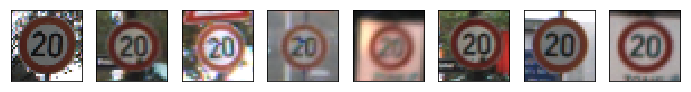

Class ID: 1  |  Sign Name : Speed limit (30km/h)


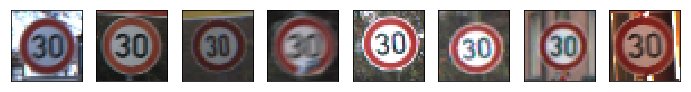

Class ID: 2  |  Sign Name : Speed limit (50km/h)


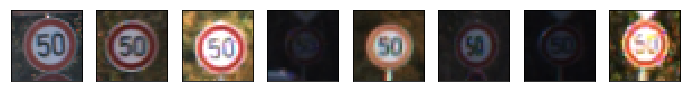

Class ID: 3  |  Sign Name : Speed limit (60km/h)


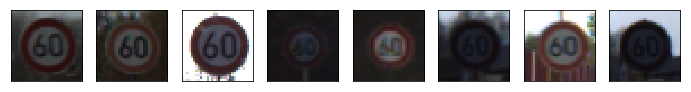

Class ID: 4  |  Sign Name : Speed limit (70km/h)


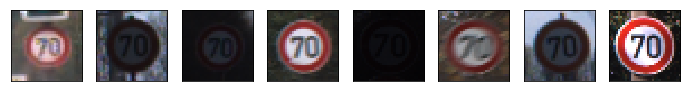

Class ID: 5  |  Sign Name : Speed limit (80km/h)


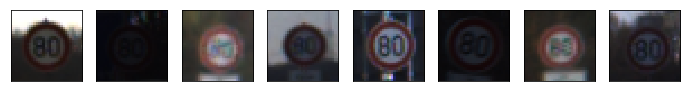

Class ID: 6  |  Sign Name : End of speed limit (80km/h)


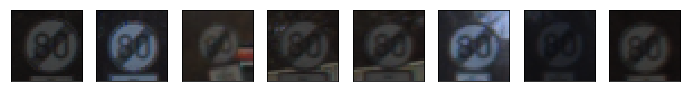

Class ID: 7  |  Sign Name : Speed limit (100km/h)


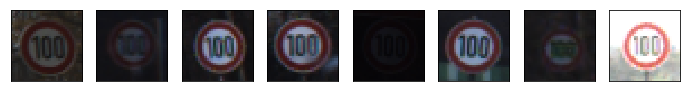

Class ID: 8  |  Sign Name : Speed limit (120km/h)


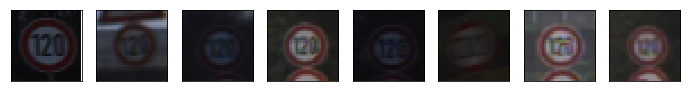

Class ID: 9  |  Sign Name : No passing


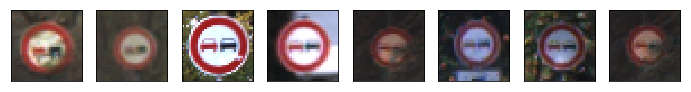

Class ID: 10  |  Sign Name : No passing for vehicles over 3.5 metric tons


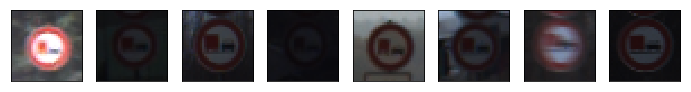

Class ID: 11  |  Sign Name : Right-of-way at the next intersection


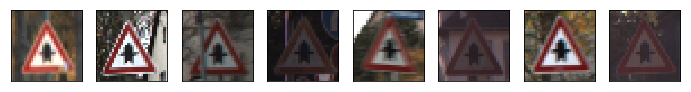

Class ID: 12  |  Sign Name : Priority road


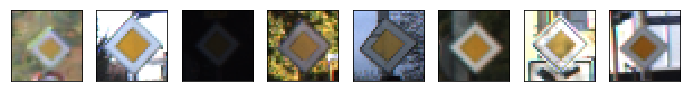

Class ID: 13  |  Sign Name : Yield


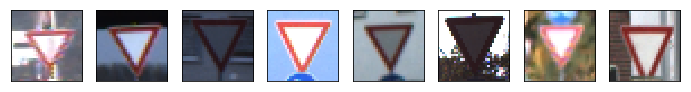

Class ID: 14  |  Sign Name : Stop


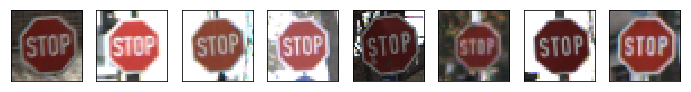

Class ID: 15  |  Sign Name : No vehicles


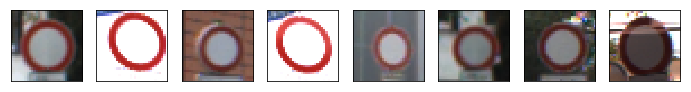

Class ID: 16  |  Sign Name : Vehicles over 3.5 metric tons prohibited


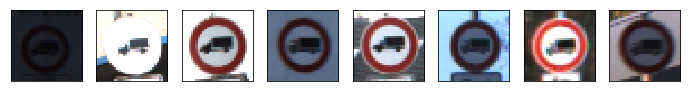

Class ID: 17  |  Sign Name : No entry


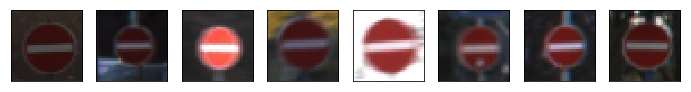

Class ID: 18  |  Sign Name : General caution


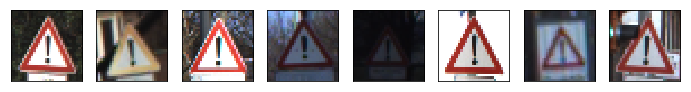

Class ID: 19  |  Sign Name : Dangerous curve to the left


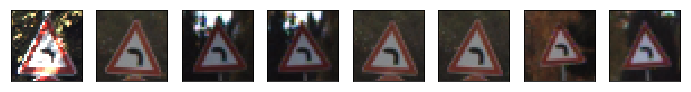

Class ID: 20  |  Sign Name : Dangerous curve to the right


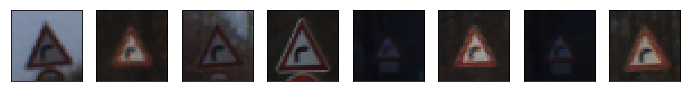

Class ID: 21  |  Sign Name : Double curve


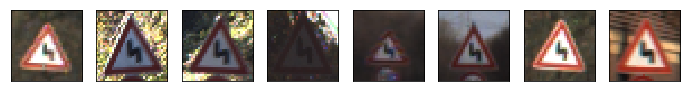

Class ID: 22  |  Sign Name : Bumpy road


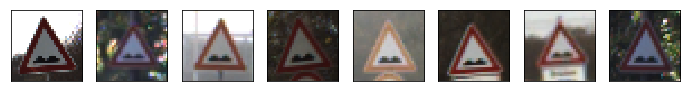

Class ID: 23  |  Sign Name : Slippery road


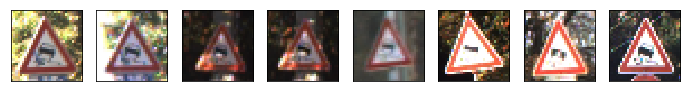

Class ID: 24  |  Sign Name : Road narrows on the right


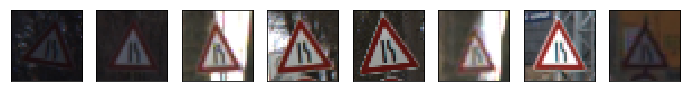

Class ID: 25  |  Sign Name : Road work


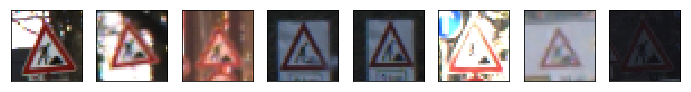

Class ID: 26  |  Sign Name : Traffic signals


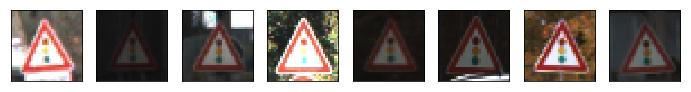

Class ID: 27  |  Sign Name : Pedestrians


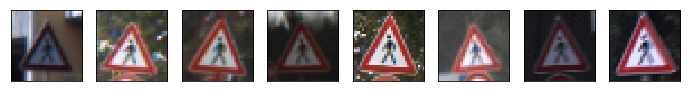

Class ID: 28  |  Sign Name : Children crossing


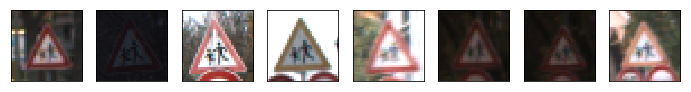

Class ID: 29  |  Sign Name : Bicycles crossing


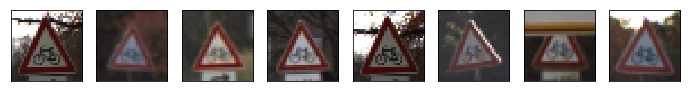

Class ID: 30  |  Sign Name : Beware of ice/snow


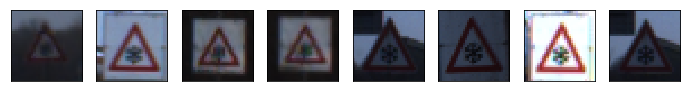

Class ID: 31  |  Sign Name : Wild animals crossing


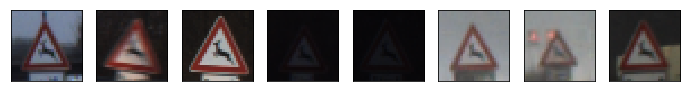

Class ID: 32  |  Sign Name : End of all speed and passing limits


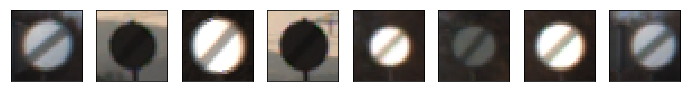

Class ID: 33  |  Sign Name : Turn right ahead


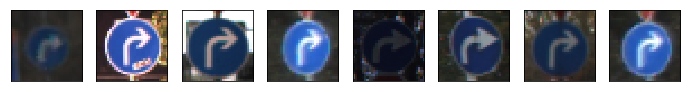

Class ID: 34  |  Sign Name : Turn left ahead


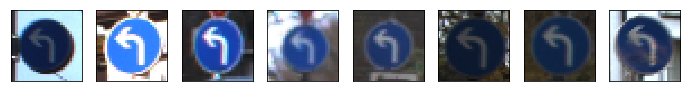

Class ID: 35  |  Sign Name : Ahead only


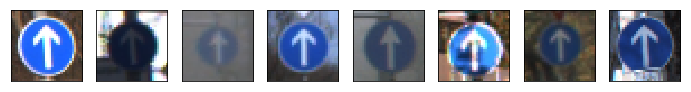

Class ID: 36  |  Sign Name : Go straight or right


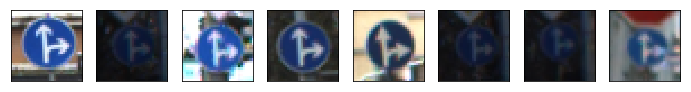

Class ID: 37  |  Sign Name : Go straight or left


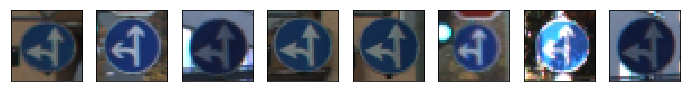

Class ID: 38  |  Sign Name : Keep right


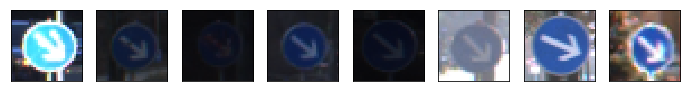

Class ID: 39  |  Sign Name : Keep left


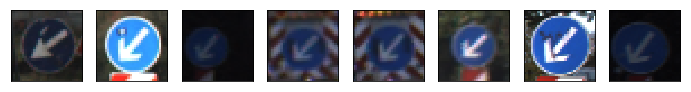

Class ID: 40  |  Sign Name : Roundabout mandatory


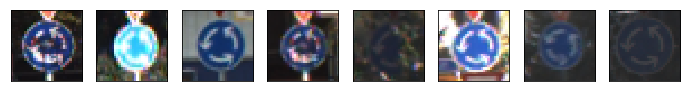

Class ID: 41  |  Sign Name : End of no passing


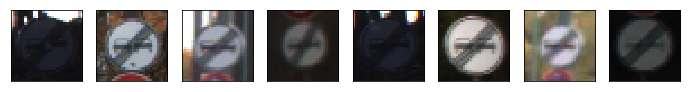

Class ID: 42  |  Sign Name : End of no passing by vehicles over 3.5 metric tons


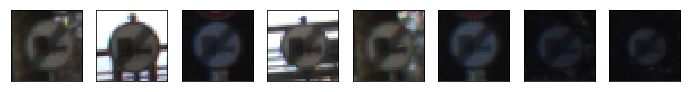

In [8]:
# Following several samples of each sign are displayed for a better understanding of the input.
all_signs_color.plot_all_signs()

#### following we create histograms of training, validation, and test sets. 
Two specifications are desired in this:
    1. Ideally, the histogram has a uniform distribution. This will assure us the training and testing data have a balanced distribution. 
    2- If (1) is not attained, which is the case, we would like to see relatively similar distributions in training, validtion, and testing data. This will assure we will have a fair analysis of our model during validation and test.

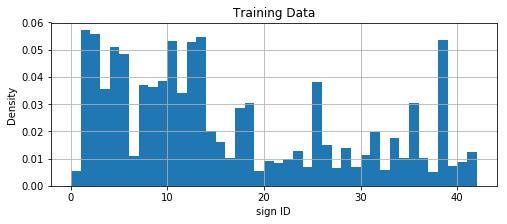

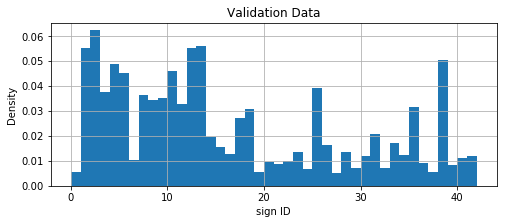

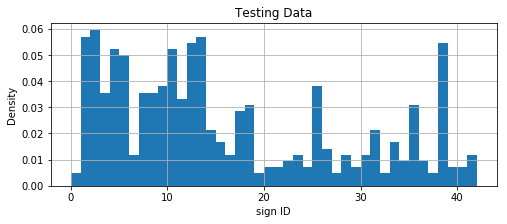

In [9]:
# Histogram of training, validation and Test:
data_sets_ = [y_train, y_valid, y_test]
data_titles_ = ['Training Data', 'Validation Data', 'Testing Data']

for i in range(0, len(data_titles_)):
    all_signs_color.plot_hist(data=data_sets_[i], title=data_titles_[i])

As you can see, the distribution of the data is not near unifrom at all. However, the distribution of the different sets is similar, which indicates a good split among sets.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

**Goal: The accuracy on the test set should be 93% or better.**

In the section, the following steps will be taken:
    - Preprocess the data.
    - Visualize the preprocessed data.
    - Build an Architecture that takes in the preprocessed inputs and predicts the sign class ID as the output.
    - Define evaluation metrics.
    - Run a TensorFlow session and train the model with the trainig data and validate with validation data.
    - Run a TensorFlow session to test the model accuracy on the test dataset


> **Note**: Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). I used the same architecture with a slight change (a simpler version, where only one layer is fed to each layer, not 2 layers).

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

I have coded the `"ImagePreprocessing"` class to provide 3 different options for preprocessing the datasets, which are combinations of normalization and grayscaling. In this project, images are first converted to grayscale by calculating the mean over the channel axis and then normalized so that every datapoint has a value between -1.0 and +1.0

In [10]:
''' This class is for preprocsessing the image files. '''

class ImagePreprocessing(object):
    
    SCALER_VAL = 128.0
    # This method normalized the value of each pixel to [-1, 1]
    def normalize_image(self, image, scaler_val=SCALER_VAL):
        scaled_ = (image - scaler_val) / scaler_val
        return scaled_
    
    # This method converts a colored image to grayscale by averaging the pixel values over 3 channels
    def color_to_grayscale(self, image, image_axis=2, keepdims=True):
        gray_ = np.mean(image, axis=image_axis, keepdims=keepdims)
        return gray_
    
    # This funciton converts an image to a preprocessed array. precprocessing is composed of normlizing and grayscaling
    def preprocess_image(self, images_array, normalize=True, to_grayscale=True):
        # By setting different flags, the preprocessing operation will be determined.
        processed_array_ = None
        if not (normalize or to_grayscale):
            processed_array_ = images_array
        elif normalize and not to_grayscale:
            processed_array_ = [self.normalize_image(image) for image in images_array]
        elif not normalize and to_grayscale:
            processed_array_ = [self.color_to_grayscale(image) for image in images_array]
        else:
            processed_array_ = [self.normalize_image(self.color_to_grayscale(image)) for image in images_array]
        return np.array(processed_array_)    

In [11]:
# Preprocess the data: preprocessing step first converts the color image to grayscale and then normalizes the grayscale image.

img_preprocess = ImagePreprocessing()
X_train_preprocessed = img_preprocess.preprocess_image(X_train, normalize=True, to_grayscale=True)
X_valid_preprocessed = img_preprocess.preprocess_image(X_valid, normalize=True, to_grayscale=True)
X_test_preprocessed = img_preprocess.preprocess_image(X_test, normalize=True, to_grayscale=True)

Class ID: 0  |  Sign Name : Speed limit (20km/h)


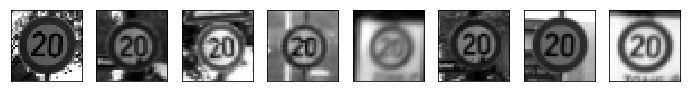

Class ID: 1  |  Sign Name : Speed limit (30km/h)


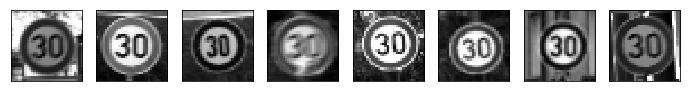

Class ID: 2  |  Sign Name : Speed limit (50km/h)


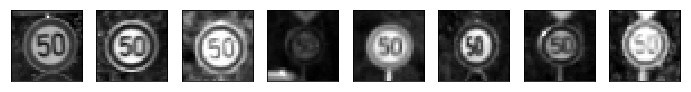

Class ID: 3  |  Sign Name : Speed limit (60km/h)


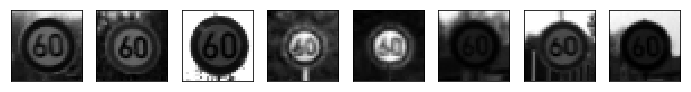

Class ID: 4  |  Sign Name : Speed limit (70km/h)


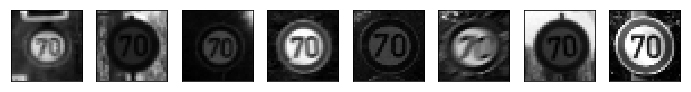

Class ID: 5  |  Sign Name : Speed limit (80km/h)


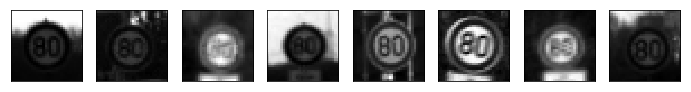

Class ID: 6  |  Sign Name : End of speed limit (80km/h)


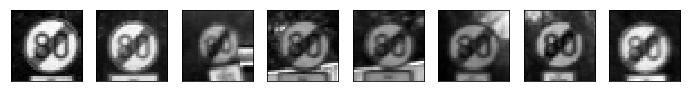

Class ID: 7  |  Sign Name : Speed limit (100km/h)


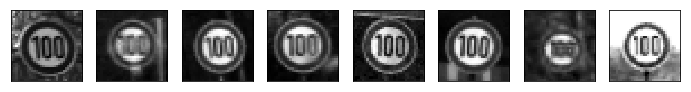

Class ID: 8  |  Sign Name : Speed limit (120km/h)


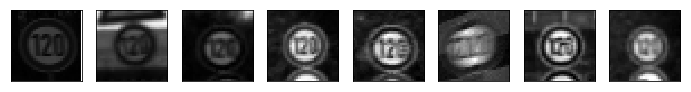

Class ID: 9  |  Sign Name : No passing


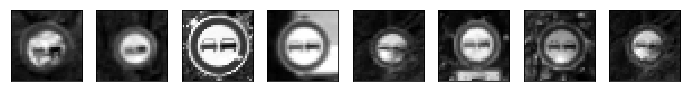

Class ID: 10  |  Sign Name : No passing for vehicles over 3.5 metric tons


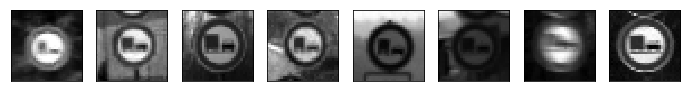

Class ID: 11  |  Sign Name : Right-of-way at the next intersection


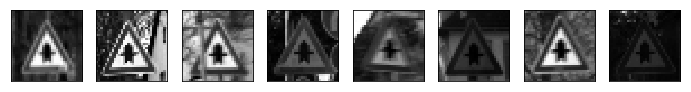

Class ID: 12  |  Sign Name : Priority road


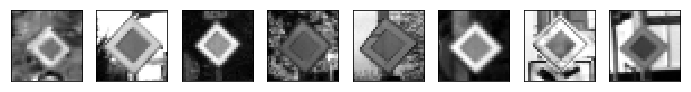

Class ID: 13  |  Sign Name : Yield


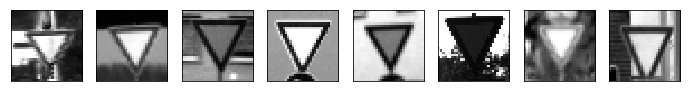

Class ID: 14  |  Sign Name : Stop


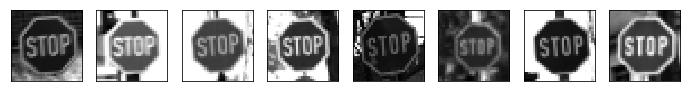

Class ID: 15  |  Sign Name : No vehicles


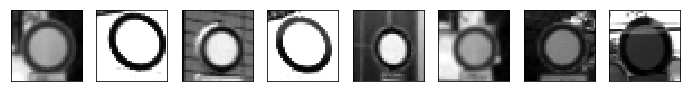

Class ID: 16  |  Sign Name : Vehicles over 3.5 metric tons prohibited


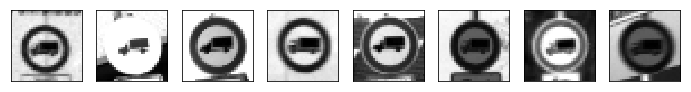

Class ID: 17  |  Sign Name : No entry


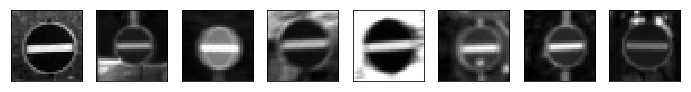

Class ID: 18  |  Sign Name : General caution


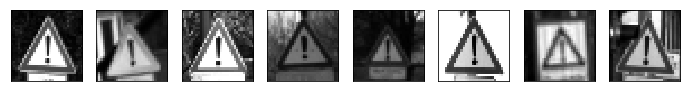

Class ID: 19  |  Sign Name : Dangerous curve to the left


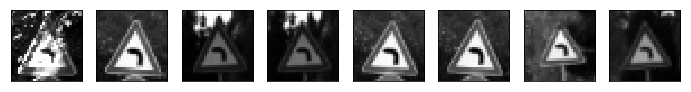

Class ID: 20  |  Sign Name : Dangerous curve to the right


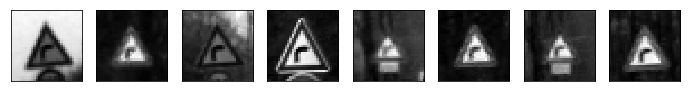

Class ID: 21  |  Sign Name : Double curve


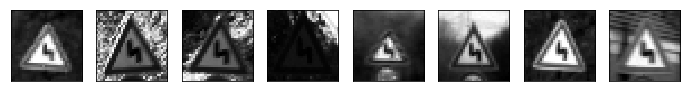

Class ID: 22  |  Sign Name : Bumpy road


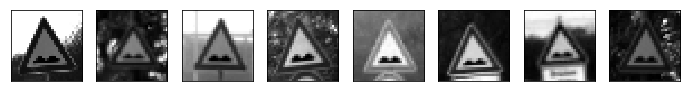

Class ID: 23  |  Sign Name : Slippery road


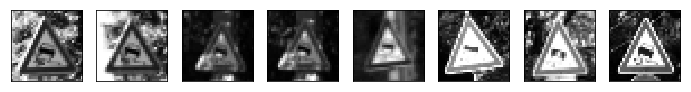

Class ID: 24  |  Sign Name : Road narrows on the right


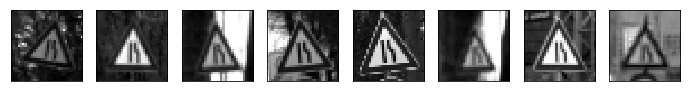

Class ID: 25  |  Sign Name : Road work


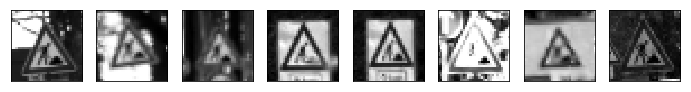

Class ID: 26  |  Sign Name : Traffic signals


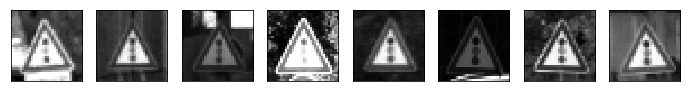

Class ID: 27  |  Sign Name : Pedestrians


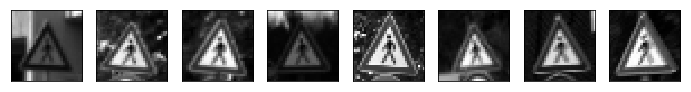

Class ID: 28  |  Sign Name : Children crossing


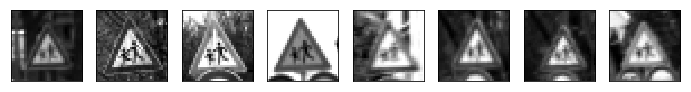

Class ID: 29  |  Sign Name : Bicycles crossing


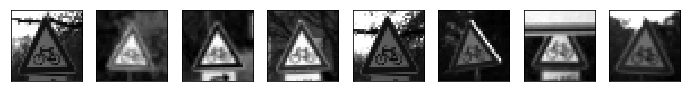

Class ID: 30  |  Sign Name : Beware of ice/snow


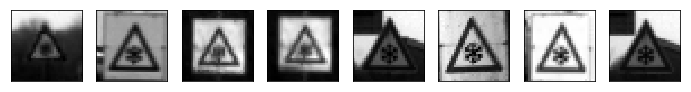

Class ID: 31  |  Sign Name : Wild animals crossing


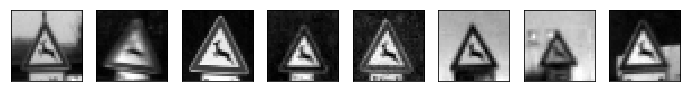

Class ID: 32  |  Sign Name : End of all speed and passing limits


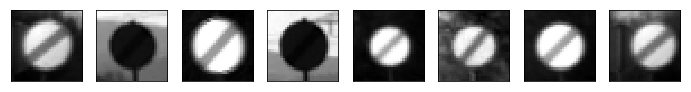

Class ID: 33  |  Sign Name : Turn right ahead


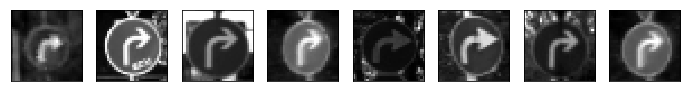

Class ID: 34  |  Sign Name : Turn left ahead


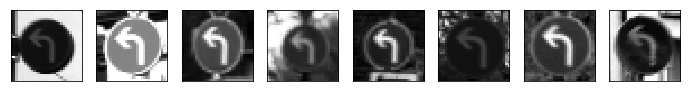

Class ID: 35  |  Sign Name : Ahead only


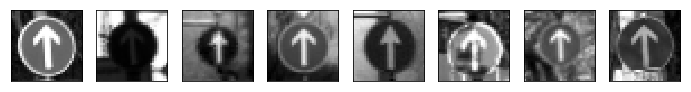

Class ID: 36  |  Sign Name : Go straight or right


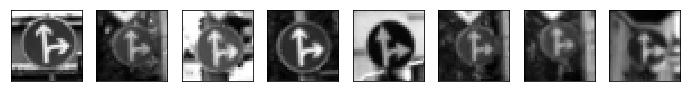

Class ID: 37  |  Sign Name : Go straight or left


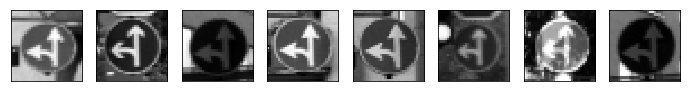

Class ID: 38  |  Sign Name : Keep right


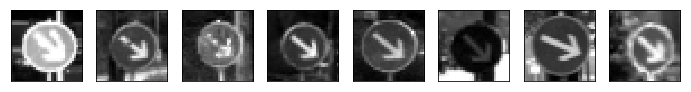

Class ID: 39  |  Sign Name : Keep left


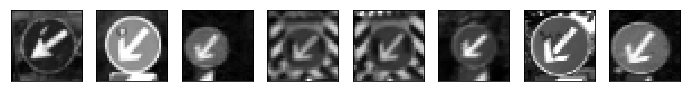

Class ID: 40  |  Sign Name : Roundabout mandatory


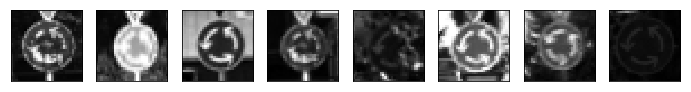

Class ID: 41  |  Sign Name : End of no passing


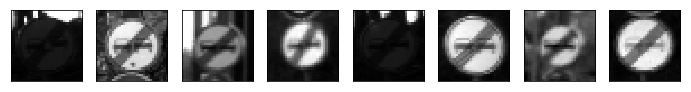

Class ID: 42  |  Sign Name : End of no passing by vehicles over 3.5 metric tons


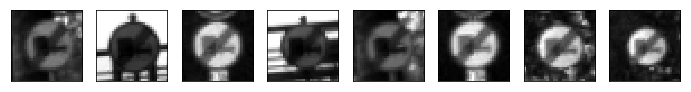

In [12]:
# In this section, we display the normalized version of the images shown in previous sections for each sign
# We do not plot the histogram since that should not change.

plot_all_normal = Visuals(X=X_train_preprocessed, y=y_train)
plot_all_normal.plot_all_signs(gray_scale=True)

<br>As you can see in the displayed preprocessed images, the geometric characteristics (shapes, relative sizes) that were present in the raw images seem to be preserved in the preprocessing process, which is a good sign in image processing. This is useful to know since it assures us that our architecture is likely to capture the same characteristics as the original data (except color off course, which does not seem to be a crucial player in this problem).

### Model Architecture

In [13]:
# Following line clears the default graph stack and resets the global default graph.
tf.reset_default_graph()

#### Sources for the Model Architecture:
- https://www.tensorflow.org/tutorials/wide_and_deep
- https://www.tensorflow.org/get_started/mnist/beginners
- https://www.tensorflow.org/get_started/mnist/pros
- http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf

#### Following is the variation of LeNet Architecture that is used in this model.
- The Architecture is inspired by [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) by Pierre Sermanet and Yann LeCun.<br> 
- The architecture figure is also taken from the same source and slightly changed to represent the model used here.

![LeNet Architecture used in this project](my_LeNet.jpg)


In [14]:
''' Following methods are used in the architecture '''

# This method initializes the weight tensor with a truncated normal distribution
def weight_variable(shape, mean=0, stddev=0.1):
    initial = tf.truncated_normal(shape=shape, mean=mean, stddev=stddev)
    return tf.Variable(initial)

# This method initializes the bias tensor with a constant array
def bias_variable(shape, value=0.01):
    # The constant value is not zero to avoid dead neurons in training
    initial = tf.constant(value=value, shape=shape)
    return tf.Variable(initial)

# This method convolves the Weight tensor with input array (x) using a given stride and padding
def conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME'):
    return tf.nn.conv2d(x, W, strides=strides, padding=padding)

# This method (Wx + b) to a max pool layer using a given stride, filter size, and padding
def max_pool_2x2(x, padding='VALID'):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


In [15]:
''' Following, the LeNet Model is defined based on Pierre Sermanet and Yann LeCun paper on this topic. The layers are feed
sequentially; every layer has one layer as input and one layer as output.'''

# The number of nodes were chosen based on the mentioned sources as well as experimenting a few different values

def LeNet(x, num_classes=43):
    
    # Layer 1 (Conv-Pool layer) : Input shape = (32, 32, 1), Output shape = (16, 16, 32)
    W_conv1 = weight_variable(shape=[5, 5, 1, 32])
    b_conv1 = bias_variable(shape=[32])
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    
    
    # Layer 2 (Conv-Pool layer) : Input shape = (16, 16, 32), Output shape = (8, 8, 64)
    W_conv2 = weight_variable(shape=[5, 5, 32, 64])
    b_conv2 = bias_variable(shape=[64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    
    
    # Flatten the previous layer's output to feed into the next layer:
    h_pool2_flat = flatten(h_pool2)
    # Find the shape for the next layer
    pool2_shape = h_pool2.get_shape()
    W_fc1_shape = [int(pool2_shape[1] * pool2_shape[2] * pool2_shape[3]), 128] #[5 * 5 * 64, 128]
    
    # Layer 3 (Flat Layer) : Input shape = (4096), Output Layer = (128)
    W_fc1 = weight_variable(shape=W_fc1_shape)
    b_fc1 = bias_variable([128])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
    # DROPOUT: Use 'keep_prob' portion of the nodes. This is 1.0 when evaluating the performance and 
    # less less than 1.0 when training. This is mainly to avoid overfitting while training
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob=keep_prob)
    
    
    # Find the shape for the next layer
    W_fc2_shape = [int(h_fc1_drop.get_shape()[1]), num_classes]
    
    # Layer 4 (Fully connected layer) : Input shape = (128), Output shape = (43)
    W_fc2 = weight_variable(shape=W_fc2_shape)
    b_fc2 = bias_variable([num_classes])
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    
    return y_conv
    

#### Following, we initialize the variables.

In [16]:
''' Initializing input variables for LeNet architecture'''

input_shape = X_train_preprocessed[0].shape # (32, 32, 1)

x = tf.placeholder(tf.float32, shape=[None] + list(input_shape))
y_ = tf.placeholder(tf.int32, shape=(None))
y_one_hot = tf.one_hot(indices=y_, depth=n_classes)
keep_prob = tf.placeholder(tf.float32)
logits = LeNet(x)

#### Following, we define the metrics and methods used in training and evaluation.

In [17]:
''' Defining optimizer parameters to feed into methods that will be used in the session'''

learning_rate = 0.001 
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_one_hot, logits=logits))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_step = optimizer.minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [18]:
# Defining the batch size and epochs.

BATCH_SIZE = 256
EPOCHS = 10

In [19]:
''' Defining the methods that will be used in the session. '''

# This method returns the accuracy of the input data by comparing the prediction of the model with the actual labels
def accuracy_score(X, y, batch_size=BATCH_SIZE, accuracy_metric=accuracy):
    session = tf.get_default_session()
    accuracy_sums = 0.0
    for start in range(0, len(X), batch_size):
        X_batch = X[start : start + batch_size]
        y_batch = y[start : start + batch_size]
        accuracy_batch = session.run(accuracy_metric, feed_dict={x : X_batch, y_ : y_batch, keep_prob : 1.0})
        # The weight (= batch size) is included in the accuracy calculation for cases where the batch size does not 
        # divide the size of the data. Usually the last batch has a different size.
        accuracy_sums += len(X_batch) * accuracy_batch
    accuracy_score = accuracy_sums / len(X)
    return accuracy_score #  0 <= score <= 1 
    
# This method performs one epoch in a given session.
def do_train_epoch(session, X_train_preprocessed, y_train, 
                 X_valid_preprocessed, y_valid, 
                 batch_size=BATCH_SIZE):
    # Shuffling the data to makes sure the samples are not ordered in a certain way
    X_train_shuffled, y_train_shuffled = shuffle(X_train_preprocessed, y_train)
    
    for start in range(0, len(X_train_shuffled), batch_size):
        X_batch = X_train_shuffled[start: start + batch_size]
        y_batch = y_train_shuffled[start: start + batch_size]
        session.run(training_step, feed_dict={x : X_batch, y_ : y_batch, keep_prob : 0.4})
    # check the accuracy for 10% of the training data as well as the validation data
    training_score = accuracy_score(X_train_shuffled[:int(n_train/10)], y_train_shuffled[:int(n_train/10)])
    validation_score = accuracy_score(X_valid_preprocessed, y_valid)
    # Printing the results
    print('Epoch {} : '.format(epoch + 1))
    print('training accuaracy : {:.2f} %    |    '.format(100.0 * training_score), end='')
    print('validation accuaracy : {:.2f} %\n'.format(100.0 * validation_score))
        

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [20]:
# This is to save the results
saver1 = tf.train.Saver()

In [21]:
# Directory to save the model to while training and to restore the model from while testing.
export_dir = './LeNet1/LeNet.ckpnt'

#### Training and Validation!

In [32]:
''' This block runs the session and prints the results at the end of each epoch'''

# Following runs the session for EPOCHS epochs.
with tf.Session() as session:
    print('Training started:')
    session.run(tf.global_variables_initializer())
    for epoch in range(0, EPOCHS):
        do_train_epoch(session, X_train_preprocessed, y_train,
                     X_valid_preprocessed, y_valid, EPOCHS)
    saver1.save(session, export_dir)
    print('Trianing Finished And Model Is Successfully Saved.')


Training started:
Epoch 1 : 
training accuaracy : 90.24 %    |    validation accuaracy : 89.79 %

Epoch 2 : 
training accuaracy : 96.87 %    |    validation accuaracy : 95.83 %

Epoch 3 : 
training accuaracy : 98.23 %    |    validation accuaracy : 97.38 %

Epoch 4 : 
training accuaracy : 99.25 %    |    validation accuaracy : 98.71 %

Epoch 5 : 
training accuaracy : 98.57 %    |    validation accuaracy : 98.01 %

Epoch 6 : 
training accuaracy : 99.59 %    |    validation accuaracy : 98.90 %

Epoch 7 : 
training accuaracy : 99.42 %    |    validation accuaracy : 98.86 %

Epoch 8 : 
training accuaracy : 99.49 %    |    validation accuaracy : 98.95 %

Epoch 9 : 
training accuaracy : 99.73 %    |    validation accuaracy : 98.96 %

Epoch 10 : 
training accuaracy : 99.49 %    |    validation accuaracy : 98.77 %

Trianing Finished And Model Is Successfully Saved.


#### Testing!

In [22]:
with tf.Session() as session:
    saver1.restore(session, export_dir)
    test_score = accuracy_score(X_test_preprocessed, y_test)
    print('Test accuaracy : {:.2f} %'.format(100.0 * test_score))

Test accuaracy : 94.93 %


As you can see it seems 9 epochs were sufficient since both training accuracy and validation accuracy slightly decline from 9th epoch to 10th epoch.<br>

This could be done by using an Early stopping method from tensorflow; however, since the extent of the effect is not significant (and because of the extra work of course), we do not perform it here.

### Testing Results:

#### Testing Accuracy = 94.93 %
__The accuracy is about 95%, which is a good accuracy based on the fact that a good portion of the images are not very clear and hard to detect even with human's eye__

__Source:__ 
https://www.tensorflow.org/get_started/mnist/pros#build_a_multilayer_convolutional_network

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

#### Helper functions: Following we define a few helpful methods

In [22]:
# This method finds the true label of the sign image based on the file name
def get_true_label(img_path):
    return (img_path.split('/')[-1]).split('.')[0]

# This method finds the true class ide of the sign image based on the file name
def get_true_class_id(img_path):
    return int((img_path.split('/')[-1]).split('.')[1])

# This method finds the image paths of images in my "test_images" directory.
def get_img_paths(img_dir):
    img_paths = [img_path.replace("\\", "/") for img_path in glob(img_dir + '/*')]
    return img_paths

# This method returns the image (tensor) of the given path:
def image_tensor(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    return cv2.resize(image, (32, 32))

### Load and Output the Images

In [23]:
test_images_dir = './test_images/'

The true label of the sign is: general_caution


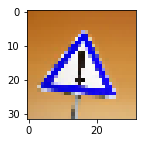

The true label of the sign is: no-entry


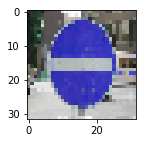

The true label of the sign is: right-of-way


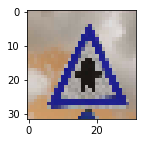

The true label of the sign is: road-work


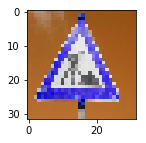

The true label of the sign is: stop


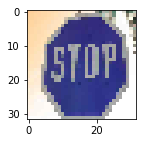

The true label of the sign is: turn_left_ahead


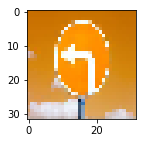

The true label of the sign is: turn_right_ahead


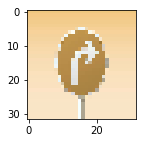

The true label of the sign is: yield


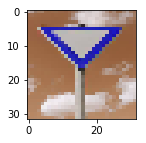

In [24]:
for path in get_img_paths(test_images_dir):
    all_signs_color.display_image(image=image_tensor(path), true_class=get_true_label(path))
    plt.show()

#### Note:
Note that The color of the images has changed. This is probably due to "cv2.imread". However, later we can see that this seems to not affect the results!

### Predict the Sign Type for Each Image

In [25]:
''' 
This is a method that accepts image path as input with a strings.ClassID.extension such as 
"./test_images/chilren_cross.28.jpg" and returns the class ID prediction of the input image and if the precition is correct! 

Note that this method is desinged to be used on a SINGLE image. This method is slow since it creates a new session and 
restore the model for every single session. Therefore, this is not supposed to be used to evaluate the performance of large 
datasets. For large datasets, a pipeline similar to what already used for (X_test, y_test) should be created to evaluate 
all the inputs in a single session.

'''


def predict_class_id(image_path, visuals_object=all_signs_color, verbose=0):
    image = image_tensor(image_path)
    image_preprocessed = np.array(img_preprocess.preprocess_image([image])[0])
    image_true_id = get_true_class_id(image_path)
    predicted_id = None
    def predict_class_id_helper(session, image=image_preprocessed):
        predicted_id = session.run(tf.argmax(logits, 1), feed_dict={x: [image], keep_prob: 1.0})
        return predicted_id[0]
    
    with tf.Session() as session:
        saver1.restore(session, export_dir)
        predicted_id = predict_class_id_helper(session=session)
        correct_pred = (image_true_id == predicted_id)
        
        # verbose 1 prints the results in an easily readable way
        if verbose >= 1:
            if correct_pred: 
                print('Correct Prediction!    |    ', end='')
            else:
                print('Incorrect Prediction!    |    ', end='')
            
            print('True Class ID : {}    |    '.format(image_true_id), end='')
            print('Predicted Class ID: {}'.format(predicted_id))
        
        # verbose 2 prints the results as well as the 32*32*3 image and the processed 32*32*1 image
        if verbose >= 2:
            
            visuals_object.display_image(image=image_tensor(image_path), true_class=None, show_title=False)
            visuals_object.display_image(image=image_preprocessed, true_class=None, gray_scale=True, show_title=False)
            plt.show()
        
        return (correct_pred, image_true_id, predicted_id)
    

Correct Prediction!    |    True Class ID : 18    |    Predicted Class ID: 18


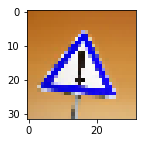

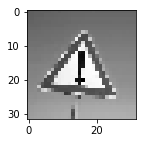

Correct Prediction!    |    True Class ID : 17    |    Predicted Class ID: 17


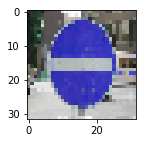

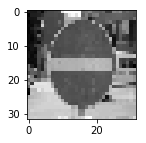

Correct Prediction!    |    True Class ID : 11    |    Predicted Class ID: 11


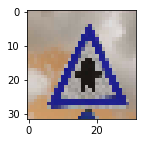

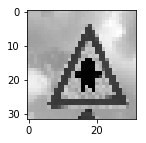

Correct Prediction!    |    True Class ID : 25    |    Predicted Class ID: 25


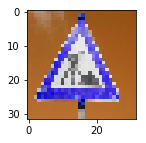

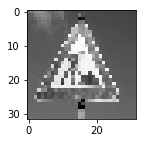

Correct Prediction!    |    True Class ID : 14    |    Predicted Class ID: 14


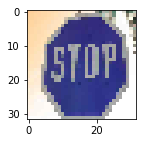

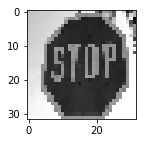

Correct Prediction!    |    True Class ID : 34    |    Predicted Class ID: 34


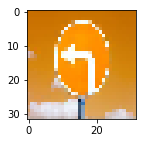

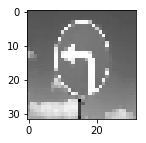

Correct Prediction!    |    True Class ID : 33    |    Predicted Class ID: 33


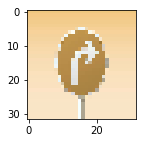

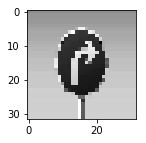

Correct Prediction!    |    True Class ID : 13    |    Predicted Class ID: 13


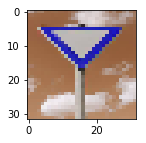

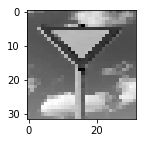

In [26]:
for path in get_img_paths(test_images_dir):
    pred_ = predict_class_id(path, verbose=2)

### Analyze Performance

In [27]:
### Calculate the accuracy for these new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

def accuracy_new_images(test_images_dir=test_images_dir):
    score = 0.0
    num_images = 0
    for path in get_img_paths(test_images_dir):
        num_images += 1
        if predict_class_id(path, verbose=0)[0]:
            score += 1
    
    if num_images == 0:
        return 'No images in the directory!'
    score = score * 100.0 / num_images
    return score


In [28]:
print('The accuracy of the model on the new test images from the web is {} %'.format(accuracy_new_images()))

The accuracy of the model on the new test images from the web is 100.0 %


#### Results on images from the web
As you can see in the previous cell, the model predicted all the images correctly. This could be due to good luck since 8 images are not indicative of the performance. However, we already have the test accuracy of about 95% on the thousands of images in the test set.<br>

In order to get the same performance on the new images, we need to make sure of the following:
    1. Ideally, we would like the images to be in the same frmat. i.e. squared-shaped with the sign near the center of the image without a tilt
    2. If (1) is not possible, we need to include a step in preprocessing to identify the border of the signs and remove the unnecessary parts of the image such as the trees, etc. 

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

In [29]:
''' 
This is a method that accepts image path as input with a strings.ClassID.extension such as 
"./test_images/chilren_cross.28.jpg", displays the image and its top k probabilities/class_id's of the predictions as a 
bar graph, and finally returns the top k probabilities/class_id's for the prediction made.

Note that this method is desinged to be used on a SINGLE image. This method is slow since it creates a new session and 
restore the model for every single session. Therefore, this is not supposed to be used to evaluate the performance of large 
datasets. For large datasets, a pipeline similar to what already used for (X_test, y_test) should be created to evaluate 
all the inputs in a single session.

'''

def show_top_k_prob(image_path, k=5, figsize=(12, 2)):
    
    if k >= n_classes:
        print('k is too large! k MUST be smaller than {}!'.format(n_classes))
        return
    
    image = image_tensor(image_path)
    image_preprocessed = np.array(img_preprocess.preprocess_image([image])[0])
    image_true_id = get_true_class_id(image_path)
    
    def top_k_probs_helper(session, image=image_preprocessed, k=k):
        top_k = session.run(tf.nn.top_k(tf.nn.softmax(logits), k=k), feed_dict={x: [image], keep_prob: 1.0})
        return (top_k.values[0], top_k.indices[0])
    
    with tf.Session() as session:
        saver1.restore(session, export_dir)
        top_k = top_k_probs_helper(session)
        
        print('True Class ID : {}'.format(image_true_id))
        #visuals_object.display_image(image=image_tensor(image_path), true_class=None, show_title=False)
        plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        plt.imshow(image_tensor(image_path))
        plt.subplot(1, 2, 2)
        plt.barh(range(1, k + 1), top_k[0])
        plt.yticks(range(1, k + 1), top_k[1])
        plt.show()
        print('_______________________________________________________________')
        return top_k

In [30]:
# Display the top 5 probabilites for the images from the web

def top_k_probs(test_images_dir=test_images_dir):
    for path in get_img_paths(test_images_dir):
        top_k_= show_top_k_prob(path)


True Class ID : 18


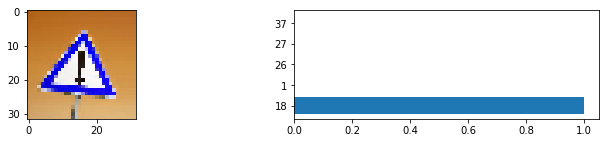

_______________________________________________________________
True Class ID : 17


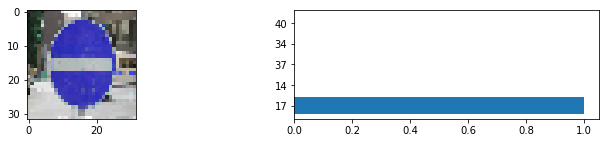

_______________________________________________________________
True Class ID : 11


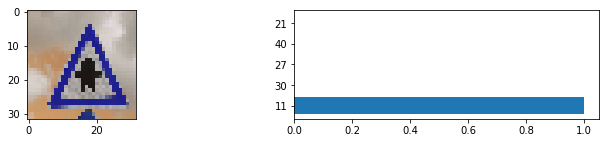

_______________________________________________________________
True Class ID : 25


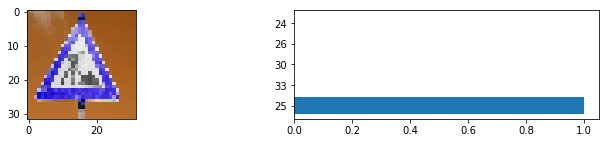

_______________________________________________________________
True Class ID : 14


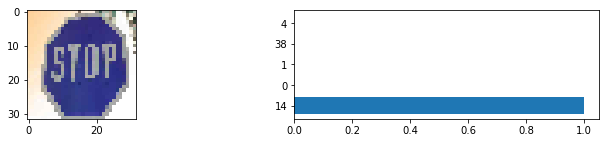

_______________________________________________________________
True Class ID : 34


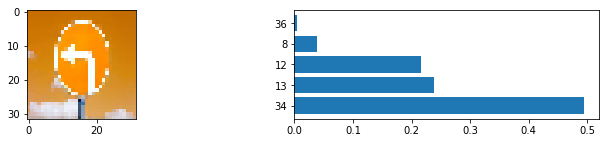

_______________________________________________________________
True Class ID : 33


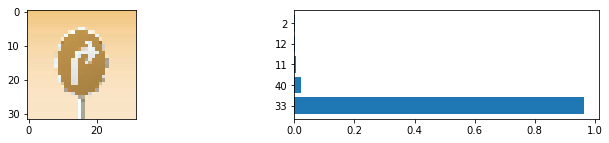

_______________________________________________________________
True Class ID : 13


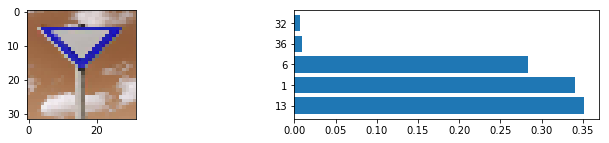

_______________________________________________________________


In [31]:
top_k_probs(test_images_dir=test_images_dir)

- As you can observe in the printed probabilities, there is no uncertainty in the prediction of some of the signs, there is small uncertainty in some, and there is high uncertainty in others. 
- It is difficult to find out the reason behind this behavior for sure. However, based on the results, it seems that signs with very distinct features, where are not found in other signs are predicted with low uncertainty, while sings with lower distinct features have higher uncertainty in the prediction.
- Note that the point mentioned above makes a lot of sense based on how CNN works. It is also intuitive to human's to human's perception.


## Final Note:

#### Following bullet points are important in this project
- In this project, a pipeline was desinged that takes images as inputs and predicts the label of the images.
- The inputs are datasets of images and true labels (classes).
- Datasets are divided into trainin (trainin, validation) and test sets.
- A simple preprocessing (normalization, grayscaling) is performed on images.
- Visualizations were done for better intuition over the data and results
- The model used in the project is a LeNet-based CNN architecture.
- Testing accuracy is about 95%, which is a decent accuracy based on the fact that some of the images are not even recognible by human's perception.
- At the end of the project, the model was tested on new images from the web. The results were desirable.
- A complete (end-to-end) pipeline was defined for a single image path as input and the label as output, which can easily be deployed within an application. The input could also be changed to the image file instead of image path too (can be done easily!). <br>
This is useful in a real application where the software application sees an image and needs to process that single image.
- Last but not least the confidence of the model results on the new images that were fed into the mentioned pipeline were anlyzed. 

<br><br>

#### Following are some of the actions could be done to slightly improve the results

- Collecting more data will be helpful since the number of the datapoints is not very large.
- Data Augmentation: The image inputs could be translated and rotated to improve the performance. Based on the nature of the problem (signs), I do not recommend flipping (mirroring) the images since the image can lead to a different sign!
- More advanced ans possibly data-specific preprocessing may help the model.
- A more advanced algorithm, especially, more advanced versions of LeNet could be used.
- Early stopping could be used to identify the best number of Epochs.
- A systematic approach, similar to GridSearch could be used to find the best hyperparameters (learning rates, optimizers, batch_size, epochs, etc.) during training. This will definitely need GPU due to extensive computational load.


# The End!